In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-05-22 05:44:25--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: 'names.txt'

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.1s    

2024-05-22 05:44:26 (1.87 MB/s) - 'names.txt' saved [228145/228145]



Loading Corpus

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

Populating Vocabulary

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

Bulding Dataset

In [6]:
block_size = 3 # context_length

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    
    return X, Y

In [7]:
import random

In [8]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### MLP

In [9]:
# MLP Revisited
n_embd = 10 # the dimensionality of the dense char embedding vector
n_hidden = 200 # the number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator = g)
W1 = torch.randn((n_hidden, n_embd * block_size), generator = g).T*(5/3)/((n_embd*block_size)**0.5)
# b1 = torch.randn(n_hidden, generator=g)*0.00
W2 = torch.randn((vocab_size, n_hidden), generator = g).T * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0.00

### Batch Normalisaiton

In [10]:
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

### Motivation for correct normalising constants

tensor(0.0035) tensor(0.9930)
tensor(0.0034) tensor(3.1627)


(array([1.95434951e-05, 6.51449835e-06, 1.95434951e-05, 1.30289967e-05,
        2.60579934e-05, 1.95434951e-05, 6.51449835e-05, 1.69376957e-04,
        2.99666924e-04, 5.60246858e-04, 9.05515271e-04, 1.70028407e-03,
        2.89895177e-03, 5.25068567e-03, 8.10403595e-03, 1.28791632e-02,
        1.98366475e-02, 3.09829542e-02, 4.40119509e-02, 6.08779871e-02,
        8.17634688e-02, 1.02121276e-01, 1.20251125e-01, 1.32100998e-01,
        1.33534187e-01, 1.24466006e-01, 1.10270914e-01, 9.02258022e-02,
        6.94901539e-02, 5.02658693e-02, 3.56343060e-02, 2.43446803e-02,
        1.54067886e-02, 9.56979808e-03, 6.14317195e-03, 3.75886555e-03,
        2.24750193e-03, 1.26381268e-03, 5.34188865e-04, 4.16927895e-04,
        1.95434951e-04, 1.17260970e-04, 6.51449835e-05, 3.25724918e-05,
        1.30289967e-05, 0.00000000e+00, 1.30289967e-05, 0.00000000e+00,
        0.00000000e+00, 6.51449835e-06]),
 array([-18.57216835, -17.80464954, -17.03713074, -16.26961193,
        -15.50209312, -14.7345

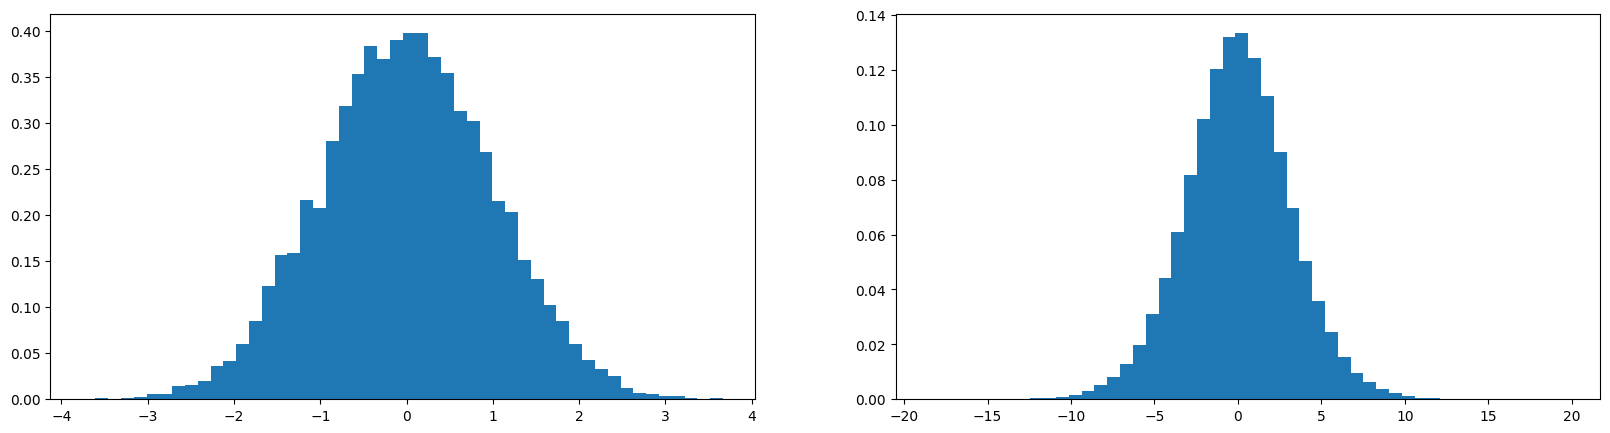

In [11]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True)

Mean remains the same, but std div has expanded, but we dont want that \
so we must scale w, correctly suchthat it preserves the gaussian \
Mathematically comes out to be divided by the squareroot of fan in, that is shape[0]
```
W1 = torch.randn((n_hidden, n_embd * block_size), generator = g).T*(5/3)/((n_embd*block_size)**0.5)
```

Most people use the inbuild `kaiming_normalisation` 

and we also need a gain included in this std normalisation as tanh is a contractive activation

### Preparing for grad

In [12]:
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [13]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # Normalisation
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2944
  10000/ 200000: 2.1204
  20000/ 200000: 2.6738
  30000/ 200000: 1.9978
  40000/ 200000: 2.2211
  50000/ 200000: 1.8527
  60000/ 200000: 2.0737
  70000/ 200000: 2.2758
  80000/ 200000: 2.3699
  90000/ 200000: 2.1287
 100000/ 200000: 2.2205
 110000/ 200000: 2.4661
 120000/ 200000: 1.7136
 130000/ 200000: 2.0199
 140000/ 200000: 2.1848
 150000/ 200000: 1.9880
 160000/ 200000: 2.0510
 170000/ 200000: 2.4521
 180000/ 200000: 2.1227
 190000/ 200000: 2.1528


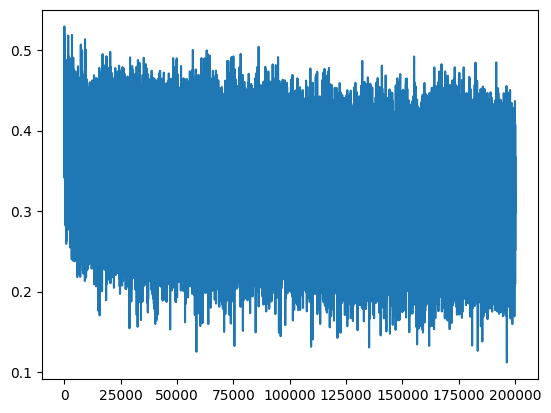

In [14]:
plt.plot(lossi)

In [15]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [16]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train' : {Xtr, Ytr},
        'val' : {Xdev, Ydev},
        'test' : {Xte, Yte}
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    hpreact =  bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0679590702056885
val 2.1088221073150635


In [17]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0]*block_size
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1) # + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break 
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out)) # decodeand print the generated word

briah.
myazlieenmilynn.
sabellascengrlot.
shelydanliths.
girenleyegssandalissathi.
shqayce.
shub.
roxhiriestin.
joxcelshnnicolfsubfatvenshyldur.
els.
gianghstlyanshinshalyanshupubialventen.
try.
bronaoellafrdin.
brookobh.
gicibroretty.
brhun.
bluisaqiifelvondwriah.
xtharshzthed.
silvissif.
fadvissivliviennakelandiyaxabiguhmi.


In [18]:
# SUMMARY + PYTORCHIFYING

## Linear

In [19]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        g = torch.Generator()
        self.W = torch.randn((fan_out, fan_in), generator = g)/(fan_in**0.5)
        self.b = torch.randn(fan_out, generator = g) if bias else None
    
    def __call__(self, X):
        self.out = self.W @ X
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])

In [20]:
layer = Linear(3, 4)
layer.parameters()

[tensor([[ 0.5642,  0.6679, -0.2198],
         [ 0.7231, -0.1772, -0.8490],
         [-0.6106,  1.1113, -0.3092],
         [-0.9023, -0.1175,  0.0178]]),
 tensor([ 1.7897,  0.5161, -1.5476, -2.6149])]

In [21]:
class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim) # bngain
        self.beta = torch.zeros(dim) # bnbias
        # buffers (trined with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # here x, is h_preactivation
        # calulate the forward pass
        if self.training:
            xmean = x.mean(0, keepdims = True) # batch mean
            xvar = x.var(0, keepdims = True) # batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1- self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum* xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [22]:
# With Learnable Parameters
m = BatchNorm1d(100)
input = torch.randn(20, 100)
output = m(input)
output

tensor([[ 0.4845,  0.8802, -0.9850,  ...,  1.4902, -1.0554, -0.8905],
        [-0.0621,  0.6297,  0.8404,  ..., -0.4603, -0.4871,  0.6373],
        [ 2.0732,  0.7235, -0.8648,  ..., -0.5073, -0.1223, -1.1811],
        ...,
        [-1.7272,  0.2821, -0.9750,  ...,  0.6151,  0.6059,  0.7223],
        [-0.2366,  1.0119, -0.1695,  ...,  1.3968, -0.0196, -0.1863],
        [ 0.7236,  0.9421,  0.8139,  ..., -1.8993,  1.4639, -0.3141]])

## Building MLP

In [23]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias = False), BatchNorm1d(vocab_size),
]

In [24]:
with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3

In [25]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024
